In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),  # Flip the image horizontally with 100% probability
    transforms.RandomRotation((90, 90)),  # Rotate 90 degrees anti-clockwise
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
train_dataset = EMNIST(root='data/', split='byclass', train=True, download=True, transform=transform)
test_dataset = EMNIST(root='data/', split='byclass', train=False, download=True, transform=transform)

In [5]:
classes = train_dataset.classes
classes

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [6]:
# Function to display an image
def imshow(img, label):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# # Select 3 random images from the dataset
# random_indices = random.sample(range(len(train_dataset)), 5)

# for idx in random_indices:
#     img, label = train_dataset[idx]
#     imshow(img, classes[label])


In [7]:
validation_split = 0.1
shuffle_dataset=True
random_seed=42

In [8]:
dataset_size = len(train_dataset)
print(f"Train Dataset Size: {dataset_size}")
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, sampler=train_sampler, num_workers=1
)
val_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, sampler=val_sampler, num_workers=1
)

Train Dataset Size: 697932


In [9]:
# Create DataLoader for test dataset
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,  # Adjust batch size as needed
    shuffle=False,  # No need to shuffle the test data
    num_workers=1   # Number of subprocesses to use for data loading
)

In [10]:
# Define a simple CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 62)  # 62 classes in the 'byclass' split

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Learning rate {0.001 -> 86%}

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    # Train the model
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        running_total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            running_total += labels.size(0)
            running_corrects += (predicted == labels).sum().item()

            # if i % 100 == 99:
                # print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}, Correct: {running_corrects / 100:.3f}, Total: {running_total / 100:.3f}')

        # Calculate the training loss and training accuracy
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * running_corrects / running_total
        train_losses.append(train_loss)  # Store train_loss

        # evaluate on the validation set
        correct = 0
        total = 0
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item() * labels.size(0)

        # Calculate the validation accuracy and validation loss
        val_accuracy = 100 * correct / total
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)  # Store val_loss

        print(f'Epoch {epoch + 1}, Train Acc:{train_accuracy:.3f}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, Val Acc: {val_accuracy:.3f}')

    print('Finished Training')
    return train_losses, val_losses

In [13]:
# Function to evaluate the model
def evaluate_model(model, test_loader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')


In [14]:
# Train the model
# train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)
# Run code from here to use pretrained weights
model.load_state_dict(torch.load("model2_weights.pth"))
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=62, bias=True)
)

In [15]:
# def plot_losses(train_losses, val_losses):
#     epochs = range(1, len(train_losses) + 1)
    
#     plt.figure(figsize=(12, 6))
    
#     # Plot training loss
#     plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    
#     # Plot validation loss
#     plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    
#     # Add labels and title
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Training and Validation Loss over Epochs')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# plot_losses(train_losses, val_losses)


In [16]:
# Evaluate the model
evaluate_model(model, test_loader, device)

Accuracy of the model on the test images: 86.33%


In [17]:
# def show_misclassified_images(model, dataloader, device):
#     model.eval()
#     misclassified = []
#     with torch.no_grad():
#         for images, labels in dataloader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             for i in range(len(labels)):
#                 if predicted[i] != labels[i]:
#                     misclassified.append((images[i].cpu(), predicted[i].item(), labels[i].item()))

#     for img, pred, actual in misclassified[:10]:  # Show the first 10 misclassified images
#         img = img.squeeze().numpy()
#         plt.imshow(img, cmap='gray')
#         plt.title(f'Predicted: {classes[pred]}, Actual: {classes[actual]}')
#         plt.show()

# # Analyze misclassifications
# show_misclassified_images(model, val_loader, device)



In [42]:
# Function to preprocess the image
def preprocess_image(image_path, invert=False, resize=True, show_output=True):
    # Open the image file
    img = Image.open(image_path).convert('L')  # Convert to grayscale ('L' mode)

    if invert:
        # Invert the colors
        img = ImageOps.invert(img)

        if show_output:
            # Display the original grayscale image
            plt.figure()
            plt.title("Inverted Grayscale Image")
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

    if resize:
        # Resize the image to 28x28
        img = img.resize((28, 28))

        if show_output:
            # Display the resized image
            plt.figure()
            plt.title("Resized Image (28x28)")
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

    # Define the transformations: convert to tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Apply the transformations
    img_tensor = transform(img)

    # Add batch dimension (1, 1, 28, 28)
    img_tensor = img_tensor.unsqueeze(0)

    return img, img_tensor

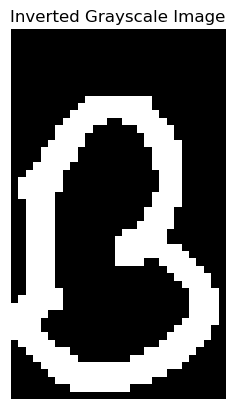

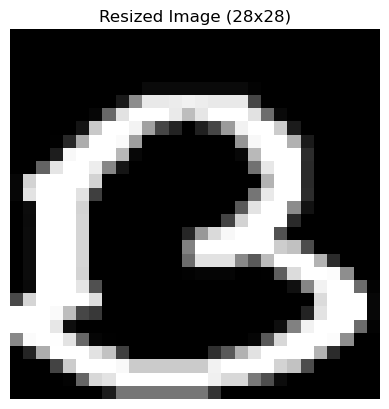

Predicted Label: B
Top 5 Probabilities:
B: 0.9996
C: 0.0003
Q: 0.0001
S: 0.0000
G: 0.0000


In [19]:
model.eval()  # Set the model to evaluation mode

# Function to predict the label of the processed image
def predict_image(model, image_tensor):
    with torch.no_grad():
        outputs = model(image_tensor.to(device))
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        return predicted.item(), probabilities.squeeze().cpu().numpy()

# Example usage
image_path = 'letter_seg/4.png'  # Replace with your image path
processed_image = preprocess_image(image_path)  # Process the image

predicted_label, probabilities = predict_image(model, processed_image)

# Predict the label of the image
print(f'Predicted Label: {classes[predicted_label]}')

# Get the top 5 probabilities and their indices
top5_probabilities_indices = np.argsort(probabilities)[-5:]  # Get indices of top 5 probabilities
top5_probabilities_indices = top5_probabilities_indices[::-1]  # Reverse to get descending order

# Print the probabilities for all classes
print('Top 5 Probabilities:')
for idx in top5_probabilities_indices:
    print(f'{classes[idx]}: {probabilities[idx]:.4f}')

In [20]:
# Function to evaluate the model
def evaluate_model(model, test_loader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')


In [21]:
# Run code from here to use pretrained weights
model.load_state_dict(torch.load("model2_weights.pth"))

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=62, bias=True)
)

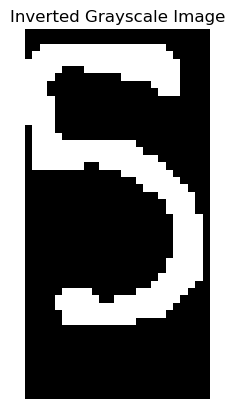

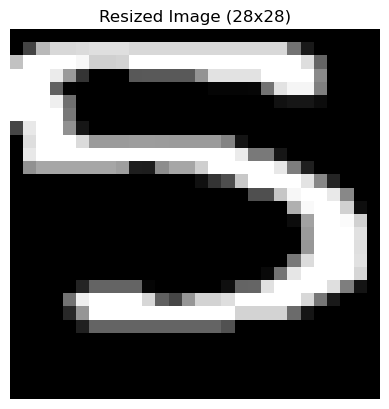

Predicted Label: D
Top 5 Probabilities:
D: 0.8661
T: 0.1272
S: 0.0061
J: 0.0003
F: 0.0002


In [22]:
model.eval()  # Set the model to evaluation mode

# Function to predict the label of the processed image
def predict_image(model, image_tensor):
    with torch.no_grad():
        outputs = model(image_tensor.to(device))
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        return predicted.item(), probabilities.squeeze().cpu().numpy()

# Example usage
image_path = 'letter_seg/2.png'  # Replace with your image path
processed_image = preprocess_image(image_path)  # Process the image

predicted_label, probabilities = predict_image(model, processed_image)

# Predict the label of the image
print(f'Predicted Label: {classes[predicted_label]}')

# Get the top 5 probabilities and their indices
top5_probabilities_indices = np.argsort(probabilities)[-5:]  # Get indices of top 5 probabilities
top5_probabilities_indices = top5_probabilities_indices[::-1]  # Reverse to get descending order

# Print the probabilities for all classes
print('Top 5 Probabilities:')
for idx in top5_probabilities_indices:
    print(f'{classes[idx]}: {probabilities[idx]:.4f}')

## Testing ground

In [31]:
from collections import defaultdict
import pandas as pd
import os


In [37]:
def load_dataset(folder, classes=None):
    if classes is None:
        classes = [dir for dir in os.listdir(folder) if os.path.isdir(os.path.join(folder, dir))]
        
    dataset = defaultdict(list)
    for img_class in classes:
        class_folder = os.path.join(folder, img_class)
        if not os.path.isdir(class_folder):
            continue
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            dataset[img_class].append(img_path)
            
    return dataset

In [38]:
def get_total_accuracy(dataset, model):
    correct = 0
    total = 0
    for img_class, img_paths in dataset.items():
        for img_path in img_paths:
            img, img_tensor = preprocess_image(img_path, show_output=False)
            predicted_label, _ = predict_image(model, img_tensor)
            if img_class == classes[predicted_label]:
                correct += 1
            total += 1
    return correct / total

In [39]:
def get_mean_probability_per_class(dataset, model):
    predicition_probabilities = defaultdict(list)
    for img_class, img_paths in dataset.items():
        for img_path in img_paths:
            img, img_tensor = preprocess_image(img_path, show_output=False)
            _, probabilities = predict_image(model, img_tensor)
            prob_correct_class = probabilities[classes.index(img_class)]
            predicition_probabilities[img_class].append(prob_correct_class)
            
    mean_probabilities = {}
    for img_class, probabilities in predicition_probabilities.items():
        mean_probabilities[img_class] = np.mean(probabilities)
    
    return mean_probabilities


In [40]:
# For each class, get the true positive count, false positive count, and false negative count
def get_image_statistics(parent_folder, images_names, model, classes):
    resultant_stats = {}

    for image_name in images_names:
        data_stats = defaultdict(dict, {class_name: {'tp': 0, 'fp': 0, 'fn': 0} for class_name in classes})

        dataset_folder = os.path.join(parent_folder, image_name, 'letters')
        dataset = load_dataset(dataset_folder, classes)
        
        for true_class, img_paths in dataset.items():
            for img_path in img_paths:
                _, img_tensor = preprocess_image(img_path, show_output=False)
                predicted_label, _ = predict_image(model, img_tensor)
                predicted_class = classes[predicted_label]
                
                if predicted_class == true_class:
                    data_stats[true_class]['tp'] += 1
                else:
                    data_stats[true_class]['fn'] += 1
                    data_stats[predicted_class]['fp'] += 1
        resultant_stats[image_name] = data_stats
    
    return resultant_stats

In [44]:

parent_folder = '/home/yilliee/ArhamSoft/Contour_NN_test'
images_folder = os.path.join(parent_folder, 'test_images')
images_names = os.listdir(images_folder)

accuracy_data = {}
probabilities_data = {}

for image_name in images_names:
    dataset_folder = os.path.join(parent_folder, image_name, 'letters')
    dataset = load_dataset(dataset_folder, classes)
    
    accuracy = get_total_accuracy(dataset, model) * 100
    accuracy_data[image_name] = accuracy
        
    mean_prob = get_mean_probability_per_class(dataset, model)
    probabilities_data[image_name] = mean_prob
    
    print(f'For {image_name}: Accuracy : {accuracy:.4f} | Mean Probability of correct_class : {np.mean(list(mean_prob.values())):.4f}')

mean_accuracy = np.mean(list(accuracy_data.values()))
print(f'\nMean accuracy: {mean_accuracy:.4f}')

For open2.jpeg: Accuracy : 66.2222 | Mean Probability of correct_class : 0.7461
For sample1.jpeg: Accuracy : 59.0909 | Mean Probability of correct_class : 0.6806
For blank.jpeg: Accuracy : 51.0000 | Mean Probability of correct_class : 0.6038
For open1.jpeg: Accuracy : 65.9898 | Mean Probability of correct_class : 0.6555

Mean accuracy: 60.5757


In [45]:
per_image_stats = get_image_statistics(parent_folder, images_names, model, classes)

In [47]:
with pd.ExcelWriter('model2_stats.xlsx') as writer:
    for image_name, image_stats in per_image_stats.items():
        df = pd.DataFrame(per_image_stats[image_name]).T
        df.to_excel(excel_writer=writer, sheet_name=image_name, index=True)

## Testing ground